# 학습은 가상환경 또는 colab에서 진행하세요 

In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...


In [3]:
%cd Mask_RCNN/

C:\Users\Sun\Desktop\test\Mask_RCNN


In [4]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info\PKG-INFO
writing dependency_links to mask_rcnn.egg-info\dependency_links.txt
writing top-level names to mask_rcnn.egg-info\top_level.txt
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build
creating build\lib
creating build\lib\mrcnn
copying mrcnn\config.py -> build\lib\mrcnn
copying mrcnn\model.py -> build\lib\mrcnn
copying mrcnn\parallel_model.py -> build\lib\mrcnn
copying mrcnn\utils.py -> build\lib\mrcnn
copying mrcnn\visualize.py -> build\lib\mrcnn
copying mrcnn\__init__.py -> build\lib\mrcnn
creating build\bdist.win-amd64
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\con

build\bdist.win-amd64\egg\mrcnn\model.py:2359: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':
zip_safe flag not set; analyzing archive contents...


In [5]:
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.2.5

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.15.0
ERROR: No matching distribution found for tensorflow-gpu==1.15.0


  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
# 파이썬 파일에 들어가서 사물명(rain) 수정
# 65 , 93, 138, 153, 173 번째 줄
# 모르겠으면 py파일을 pycharm이나 VisualStudio로 열어서 ctrl+f로 찾도록

In [ ]:
%cd ../umbrella
# %cd ../person
# %cd ../puddle
# %cd ../cloud
# %cd ../thunder

In [9]:
# 파이썬 파일  학습 명령(train)             데이터셋            가중치 정보
!python umbrella.py train --dataset="C:\Users\Sun\Desktop\test\umbrella\dataset"--weights=coco  

python: can't open file 'umbrella.py': [Errno 2] No such file or directory


# log파일에 마지막으로 학습된 h5파일 다운 받고,

# 로컬에서 MRCNN.ipynb 실행 가능

In [38]:
%cd ..
# 로그파일을 content 안에 넣고 
# bottle 파이썬 밖으로 빼서 content 안에 넣으세요
# Mark_RCNN파일 안에 있는 mrcnn을 꺼내주세요

/content


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
# ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import umbrella.umbrella
# import cloud.cloud
# import person.person
# import puddle.puddle
# import thunder.thunder


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join("logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join("mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join( "train_umbrella/dataset/val")

... done downloading pretrained model!


In [44]:
config = umbrella.CustomConfig()
UMBRELLA_DIR = os.path.join("train_umbrella/dataset")

In [45]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [46]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['umbrella']

In [47]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [50]:
# Load validation dataset
dataset = umbrella.CustomDataset()
dataset.load_custom(UMBRELLA_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 13
Classes: ['BG', 'bottle']


In [52]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [53]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  logs/bottle20210220T0302/mask_rcnn_bottle_0003.h5






Re-starting from epoch 3


image ID: bottle.ActiOn_82.jpg (1) Mask-RCNN-bottle-training/dataset/val/ActiOn_82.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  391.00000  max:  796.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


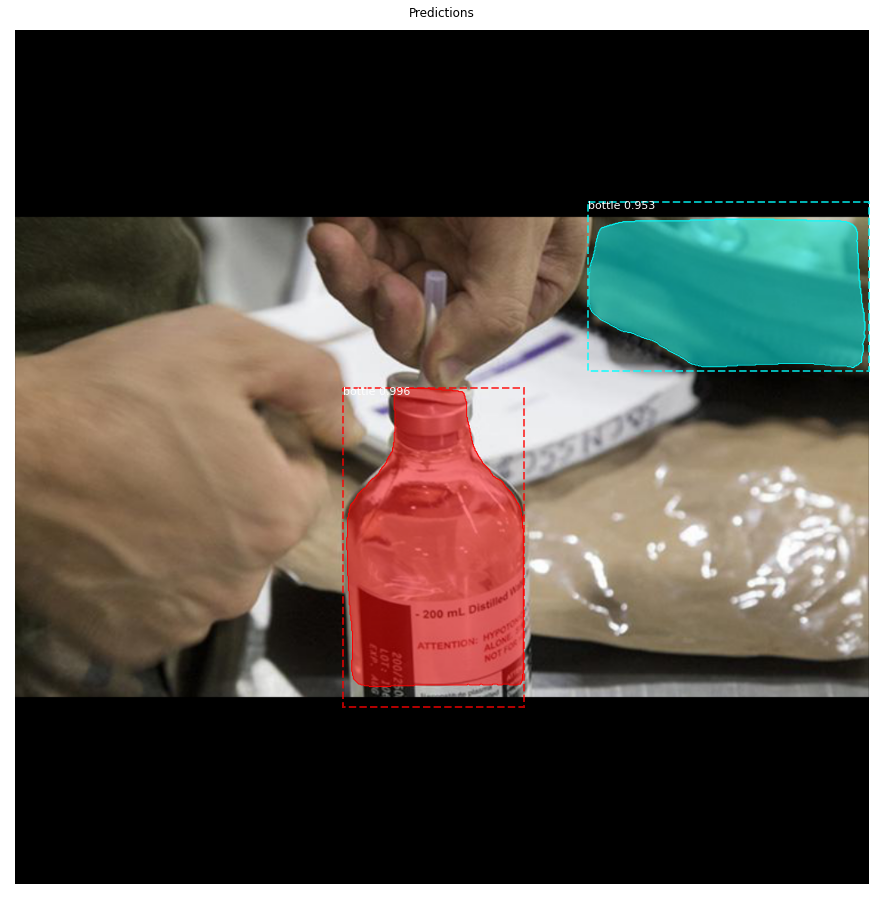

In [54]:
from PIL import Image

image = Image.open(
            os.path.join( f'0202.JPG')).convert('RGB')
image = np.array(image)
results = model.detect([image], verbose=1)
ax = get_ax(1)
r = results[0]
mask = r["masks"]
x_min = np.where(mask)[0].min()
x_max = np.where(mask)[0].max()
y_min = np.where(mask)[1].min()
y_max= np.where(mask)[1].max()
box = np.array([[x_min, x_max, y_min,y_max]])
visualize.display_instances(image, box, r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")